# Smart Water Analytics

Este proyecto dará solución al problema propuesto por la competición homonima en Kaggle.  
El principal objetivo de la competición es encontrar un modelo que prediga o determine que features son relevantes para la disponibilidad de agua, en cada tipo de cuerpo de agua. Los tipos de cuerpos de agua son. 
- acuíferos 
- ríos
- lagos. 
- manantiales

El outcome deseado es tener cuatro modelos predictores, uno por cada tipo de cuerpo de agua (acuíferos, cascadas, ríos y lagos).

# 1. Preparación del Entorno. 

Antes de cargar los datos, se importarán las librerías que se requerirán:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np


# 2. Carga de Datos y EDA inicial. 

## Carga de Datos. 

### Lake. 

In [2]:
df_lb = pd.read_csv("../data/raw/Lake_Bilancino.csv")
df_lb.head()

,Date,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
0,03/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
1,04/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
2,05/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
3,06/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.43,0.31
4,07/06/2002,NaN,NaN,NaN,NaN,NaN,NaN,249.44,0.31


In [3]:
df_lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  6603 non-null   object 
 1   Rainfall_S_Piero      6026 non-null   float64
 2   Rainfall_Mangona      6026 non-null   float64
 3   Rainfall_S_Agata      6026 non-null   float64
 4   Rainfall_Cavallina    6026 non-null   float64
 5   Rainfall_Le_Croci     6026 non-null   float64
 6   Temperature_Le_Croci  6025 non-null   float64
 7   Lake_Level            6603 non-null   float64
 8   Flow_Rate             6582 non-null   float64
dtypes: float64(8), object(1)
memory usage: 464.4+ KB


In [4]:
df_lb.describe()

,Rainfall_S_Piero,Rainfall_Mangona,Rainfall_S_Agata,Rainfall_Cavallina,Rainfall_Le_Croci,Temperature_Le_Croci,Lake_Level,Flow_Rate
count,6026.000000,6026.000000,6026.000000,6026.000000,6026.000000,6025.000000,6603.000000,6582.000000
mean,2.471225,3.340657,2.670063,2.674743,3.129871,14.530141,249.564091,2.760968
std,6.650012,8.903134,7.166643,7.655847,8.025121,6.944029,2.172558,4.073428
min,0.000000,0.000000,0.000000,0.000000,0.000000,-5.350000,243.530000,0.310000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,248.000000,0.600000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,14.500000,250.200000,1.500000
75%,0.800000,1.400000,1.200000,0.600000,1.200000,20.100000,251.400000,3.000000
max,80.600000,110.000000,120.200000,113.600000,88.400000,34.000000,252.760000,74.650000


## __EDA Inicial.__

### Análisis Univariable.

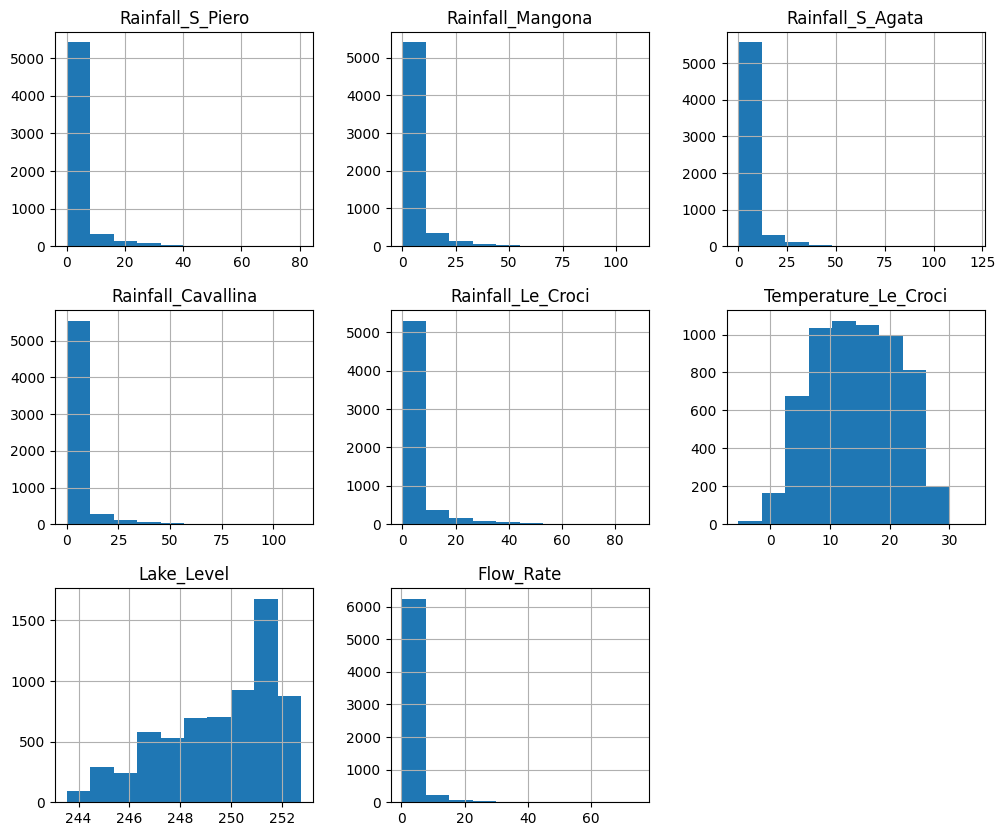

In [5]:
df_lb.hist(figsize=(12,10))
plt.show()

### Análisis Bivariado. 

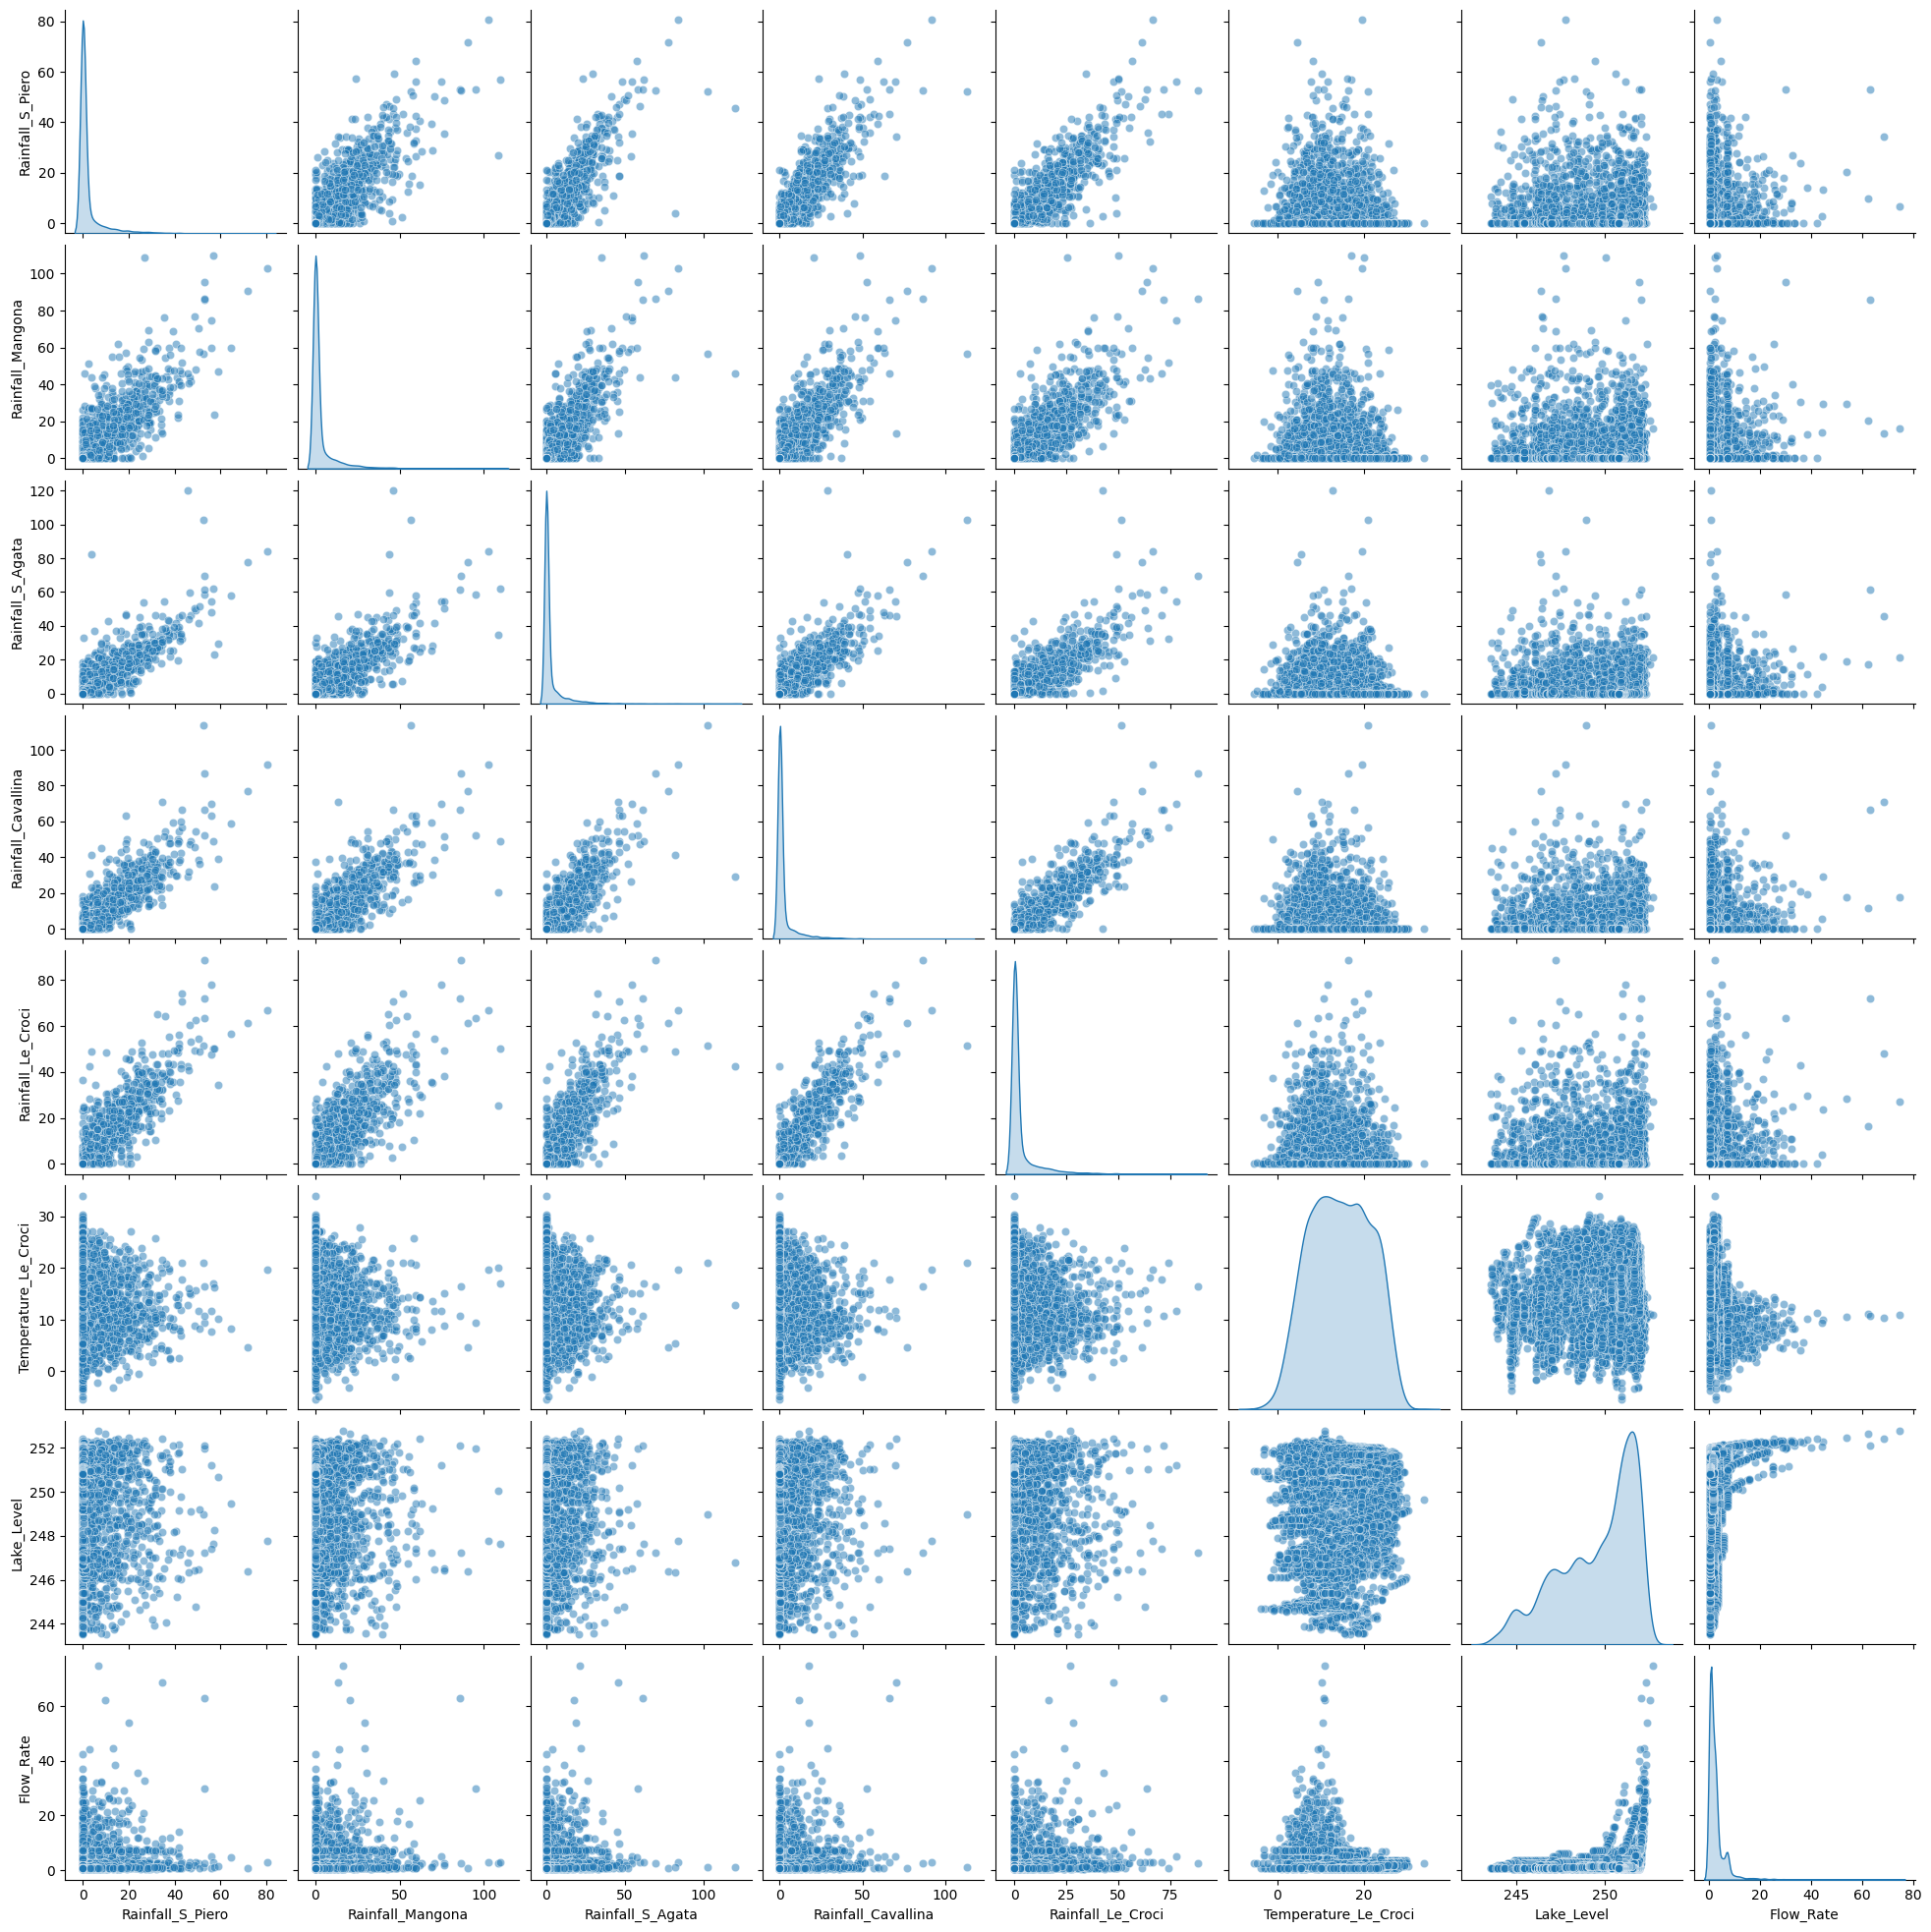

In [6]:
sns.pairplot(df_lb, diag_kind='kde', markers='o', plot_kws={'alpha': 0.5})

### Correlación. 

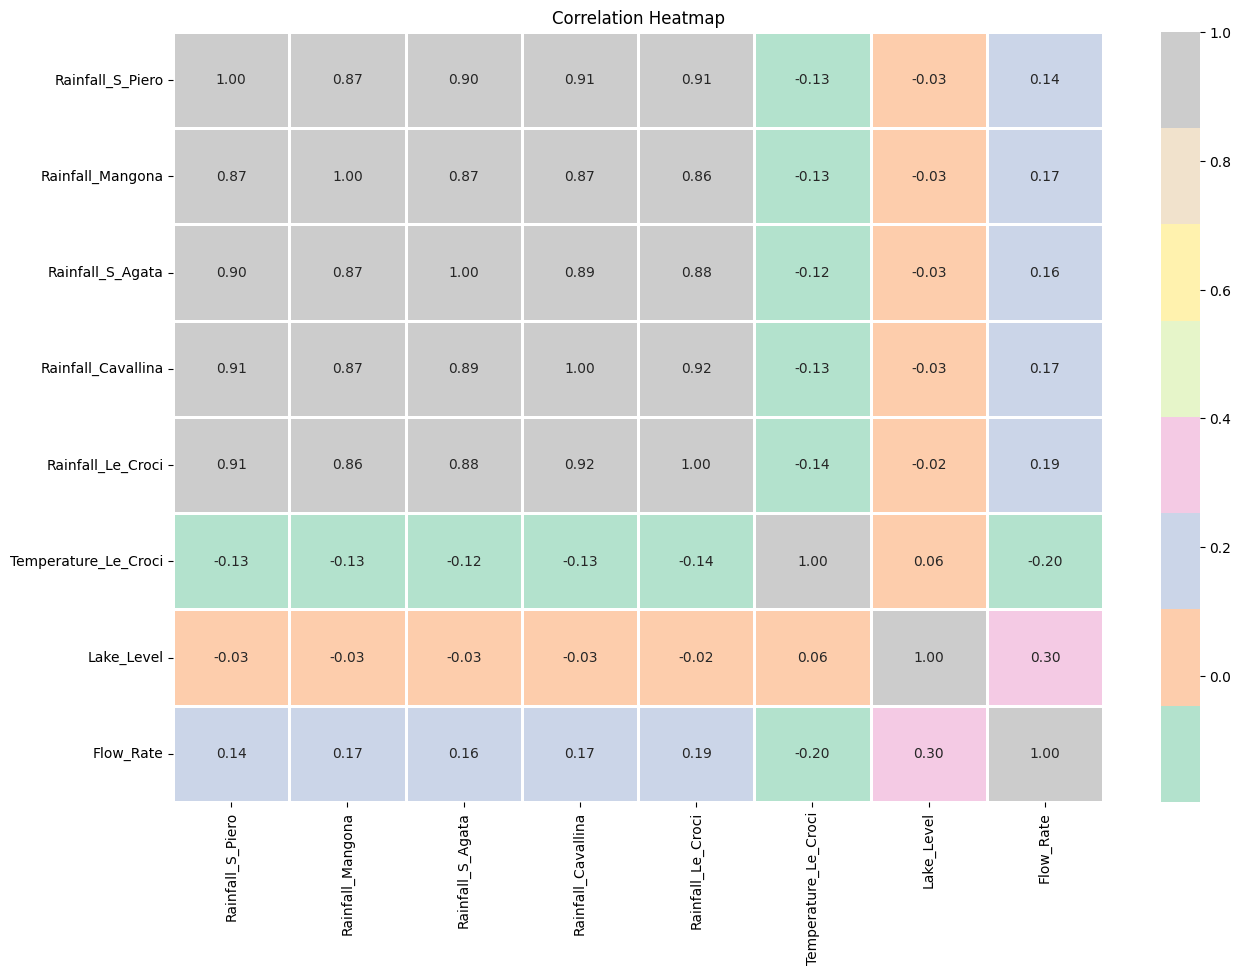

In [7]:
plt.figure(figsize=(15, 10))
df_wd = df_lb.drop(['Date'], axis=1)
sns.heatmap(df_wd.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

### __Hallazgos__

# 3. Limpieza de Datos (Data Cleansing). 

### Tratamiento de valores nulos.

In [8]:
# Eliminación de valores nulos en DataFrames
def eliminated_nulls(df):
    fecha_actual = datetime.now()
    df.fillna(0, inplace=True)
    df['Date'].fillna(fecha_actual, inplace=True)

eliminated_nulls(df_lb)


/var/folders/z5/1t80mr5s6n10j0fkr7bb6x6c0000gn/T/ipykernel_54152/1342268499.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Date'].fillna(fecha_actual, inplace=True)


### Tratamiento de Outliers.  
Función para encontrar columnas con Outliers:

In [9]:
def outliers_column(df):
    columnas_con_outliers = []
    
    # Iterar sobre cada columna del DataFrame
    for col in df.columns:
        # Asegurarse de que la columna es numérica
        if pd.api.types.is_numeric_dtype(df[col]):
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            
            # Definir los límites para los outliers
            limite_inferior = q1 - 1.5 * iqr
            limite_superior = q3 + 1.5 * iqr
            
            # Verificar si hay algún valor atípico en la columna
            outliers_presentes = ((df[col] < limite_inferior) | (df[col] > limite_superior)).any()
            
            # Si se encuentran outliers, agregar el nombre de la columna a la lista
            if outliers_presentes:
                columnas_con_outliers.append(col)
    
    return columnas_con_outliers

#### Outliers (Lago Bilancino). 

In [10]:
lb_oc = outliers_column(df_lb)
print(f"Columnas con outliers en df_aa: {lb_oc}")
df_aa_oc = df_lb[lb_oc]

Columnas con outliers en df_aa: ['Rainfall_S_Piero', 'Rainfall_Mangona', 'Rainfall_S_Agata', 'Rainfall_Cavallina', 'Rainfall_Le_Croci', 'Flow_Rate']


Función para obtener gráfico de todos los outliers:

In [11]:
def plot_outliers_boxplots(df, columns):
    # 1. Contar el número de columnas con outliers
    num_cols = len(columns)

    # 2. Definir la disposición de los subplots (ej. 2 filas, 2 columnas)
    # Esto es flexible, puedes ajustarlo según tus necesidades
    num_filas = 4
    num_columnas = int(np.ceil(num_cols / num_filas))

    # 3. Crear la figura y los subplots
    fig, axes = plt.subplots(num_filas, num_columnas, figsize=(15, 10))

    # Aplanar el array de ejes para iterar fácilmente
    axes = axes.flatten()

    # 4. Iterar sobre las columnas y dibujar el box plot en cada subplot
    for i, col in enumerate(columns):
        ax = axes[i]
        ax.boxplot(df[col], vert=False) # vert=False para que sean horizontales
        ax.set_title(f'{col}')
        ax.set_xlabel('Valores')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Ocultar los subplots que no se usen (si los hay)
    for i in range(num_cols, len(axes)):
        axes[i].axis('off')

    # Ajustar el espaciado entre subplots
    plt.tight_layout()
    plt.show()

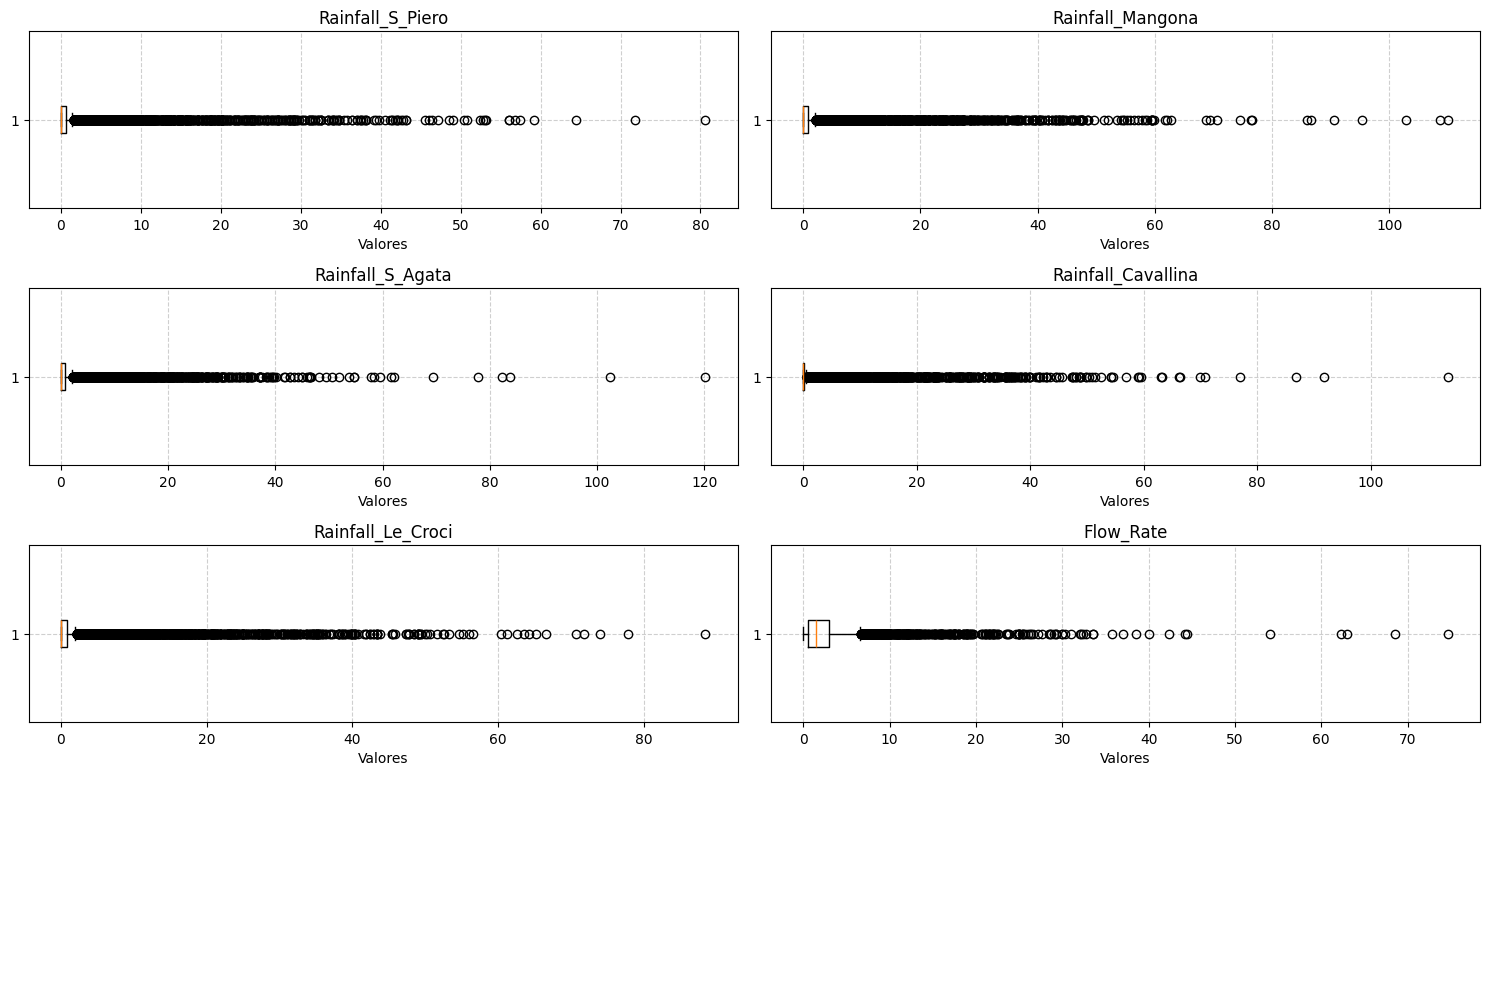

In [12]:
plot_outliers_boxplots(df_aa_oc, lb_oc)

### Cambio de tipo de datos (features).

In [13]:
# Cambiar fecha de string a datetime
df_lb['Date'] = pd.to_datetime(df_lb['Date'], format='%d/%m/%Y')
df_lb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6603 entries, 0 to 6602
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  6603 non-null   datetime64[ns]
 1   Rainfall_S_Piero      6603 non-null   float64       
 2   Rainfall_Mangona      6603 non-null   float64       
 3   Rainfall_S_Agata      6603 non-null   float64       
 4   Rainfall_Cavallina    6603 non-null   float64       
 5   Rainfall_Le_Croci     6603 non-null   float64       
 6   Temperature_Le_Croci  6603 non-null   float64       
 7   Lake_Level            6603 non-null   float64       
 8   Flow_Rate             6603 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 464.4 KB


# 4. Ingeniería de Características (Feature Engineering). 

## Transformación de formato (Wide -> Long). 

Al realizar el EDA inicial, se identificó que existen variables (features) que representan el mismo valor, pero diferente ubicación, por ejemplo, la variable __Rainfall__ esta repetida varias veces en varias ubicaciones, es por esto que se decidirá cambiar el formato del Dataframe, con el fin de obtener una sola variable, esto también ayudará a que nuestra variable target __Volume__ sea correctamente tratada.

Función general para realizar transformación de formato Wide -> Long.

In [14]:
# Transformación de formato (Wide -> Long)
def transform_wide_to_long(df, match):
    column_names_list = df.columns.tolist()
    cols_without_rainfall = [i for i in column_names_list if not i.startswith(match)]
    df_filtrado = df.filter(like=match)
    column_names_list_fil = df_filtrado.columns.tolist()
    df_long = df.melt(
                    id_vars= cols_without_rainfall,
                    value_vars= column_names_list_fil,
                    var_name= match + 'Ubication',
                    value_name= match + 'Value'
                )

    df_long.head() 
    return df_long

In [15]:
df_llb_r = transform_wide_to_long(df_lb, "Rainfall_")
df_llb_t = transform_wide_to_long(df_llb_r, "Temperature_")
df_lb = df_llb_t
df_lb.head()

,Date,Lake_Level,Flow_Rate,Rainfall_Ubication,Rainfall_Value,Temperature_Ubication,Temperature_Value
0,2002-06-03,249.43,0.31,Rainfall_S_Piero,0.0,Temperature_Le_Croci,0.0
1,2002-06-04,249.43,0.31,Rainfall_S_Piero,0.0,Temperature_Le_Croci,0.0
2,2002-06-05,249.43,0.31,Rainfall_S_Piero,0.0,Temperature_Le_Croci,0.0
3,2002-06-06,249.43,0.31,Rainfall_S_Piero,0.0,Temperature_Le_Croci,0.0
4,2002-06-07,249.44,0.31,Rainfall_S_Piero,0.0,Temperature_Le_Croci,0.0


### Variables categóricas a variables numéricas.

Ahora que se transformaron las columnas de los dataset, se convertirán las variables categóricas a variables numéricas, con el fin de facilitar el análisis.

In [16]:
def transform_ubications_to_numbers(df, column_name):
    """
    Mapea las ubicaciones de lluvia a números únicos.
    
    Args:
        df (DataFrame): DataFrame que contiene la columna de ubicaciones de lluvia.
        column_name (str): Nombre de la columna que contiene las ubicaciones de lluvia.
    
    Returns:
        DataFrame: DataFrame con la columna de ubicaciones mapeada a números.
    """
    all_ubications = df[column_name].unique()
    ubications_map = {}
    num = 1
    
    for ubication in all_ubications:
        ubications_map[ubication] = num
        num += 1

    print(f"Ubicaciones de lluvia mapeadas: {ubications_map}")

    # Mapeo de ubicaciones de lluvia a números
    df[column_name] = df[column_name].map(ubications_map)
    
    return df

In [17]:
# Aplicar la transformación a df_aa
df_lb = transform_ubications_to_numbers(df_lb, 'Rainfall_Ubication')
df_lb = transform_ubications_to_numbers(df_lb, 'Temperature_Ubication')
df_lb.head()

Ubicaciones de lluvia mapeadas: {'Rainfall_S_Piero': 1, 'Rainfall_Mangona': 2, 'Rainfall_S_Agata': 3, 'Rainfall_Cavallina': 4, 'Rainfall_Le_Croci': 5}
Ubicaciones de lluvia mapeadas: {'Temperature_Le_Croci': 1}


,Date,Lake_Level,Flow_Rate,Rainfall_Ubication,Rainfall_Value,Temperature_Ubication,Temperature_Value
0,2002-06-03,249.43,0.31,1,0.0,1,0.0
1,2002-06-04,249.43,0.31,1,0.0,1,0.0
2,2002-06-05,249.43,0.31,1,0.0,1,0.0
3,2002-06-06,249.43,0.31,1,0.0,1,0.0
4,2002-06-07,249.44,0.31,1,0.0,1,0.0


### Encontrar variables que se volvieron constantes

In [18]:
# Encontrar variables que se volvieron constantes
df_lb.describe()

,Date,Lake_Level,Flow_Rate,Rainfall_Ubication,Rainfall_Value,Temperature_Ubication,Temperature_Value
count,33015,33015.000000,33015.000000,33015.000000,33015.000000,33015.0,33015.000000
mean,2011-06-17 00:00:00,249.564091,2.752187,3.000000,2.607627,1.0,13.258231
min,2002-06-03 00:00:00,243.530000,0.000000,1.000000,0.000000,1.0,-5.350000
25%,2006-12-09 00:00:00,248.000000,0.600000,2.000000,0.000000,1.0,7.300000
50%,2011-06-17 00:00:00,250.200000,1.500000,3.000000,0.000000,1.0,13.400000
75%,2015-12-24 00:00:00,251.400000,3.000000,4.000000,0.600000,1.0,19.550000
max,2020-06-30 00:00:00,252.760000,74.650000,5.000000,120.200000,1.0,34.000000
std,NaN,2.172426,4.069668,1.414235,7.423385,0.0,7.801052


Como la desviación estándar sea 0 es indicador de que una variable es constante, se usará para eliminar aquellas features que presenten esta característica, pues no aporta información al análisis o al modelo:

In [19]:
df_lb = df_lb.loc[:, df_lb.std() != 0]
df_lb.head()

,Date,Lake_Level,Flow_Rate,Rainfall_Ubication,Rainfall_Value,Temperature_Value
0,2002-06-03,249.43,0.31,1,0.0,0.0
1,2002-06-04,249.43,0.31,1,0.0,0.0
2,2002-06-05,249.43,0.31,1,0.0,0.0
3,2002-06-06,249.43,0.31,1,0.0,0.0
4,2002-06-07,249.44,0.31,1,0.0,0.0


# 5. EDA refinado y visualización. 

### Análisis Univariado. 

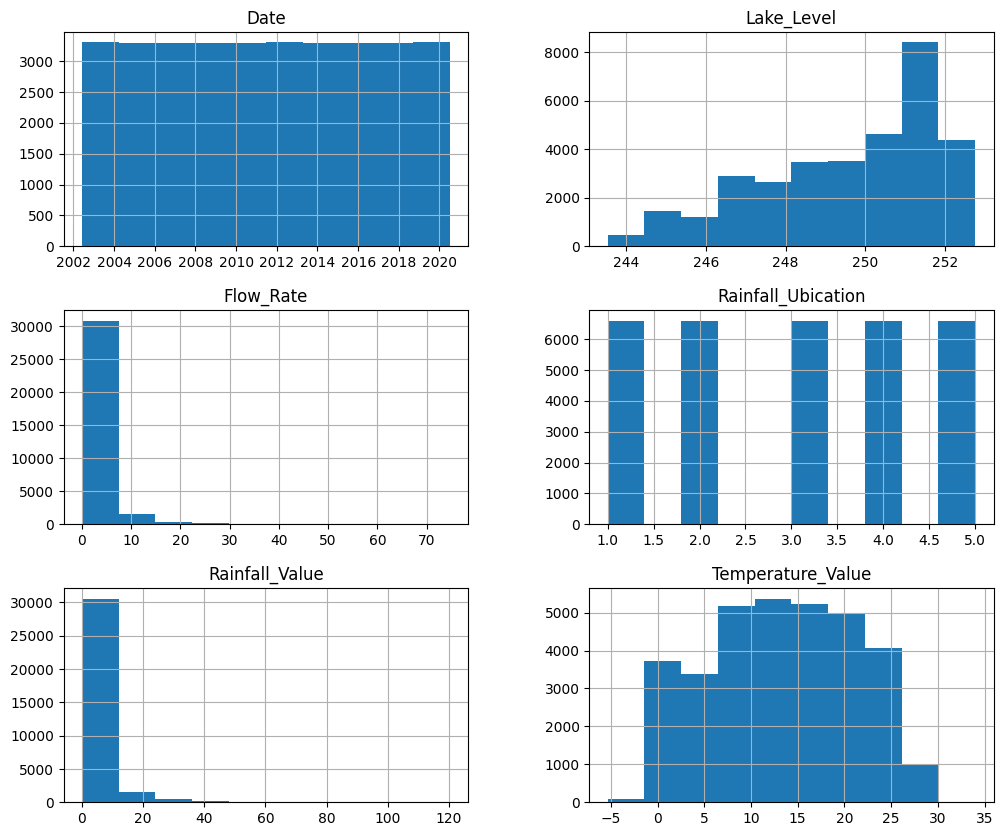

In [20]:
df_lb.hist(figsize=(12,10))
plt.show()

### Análisis Bivariado.  

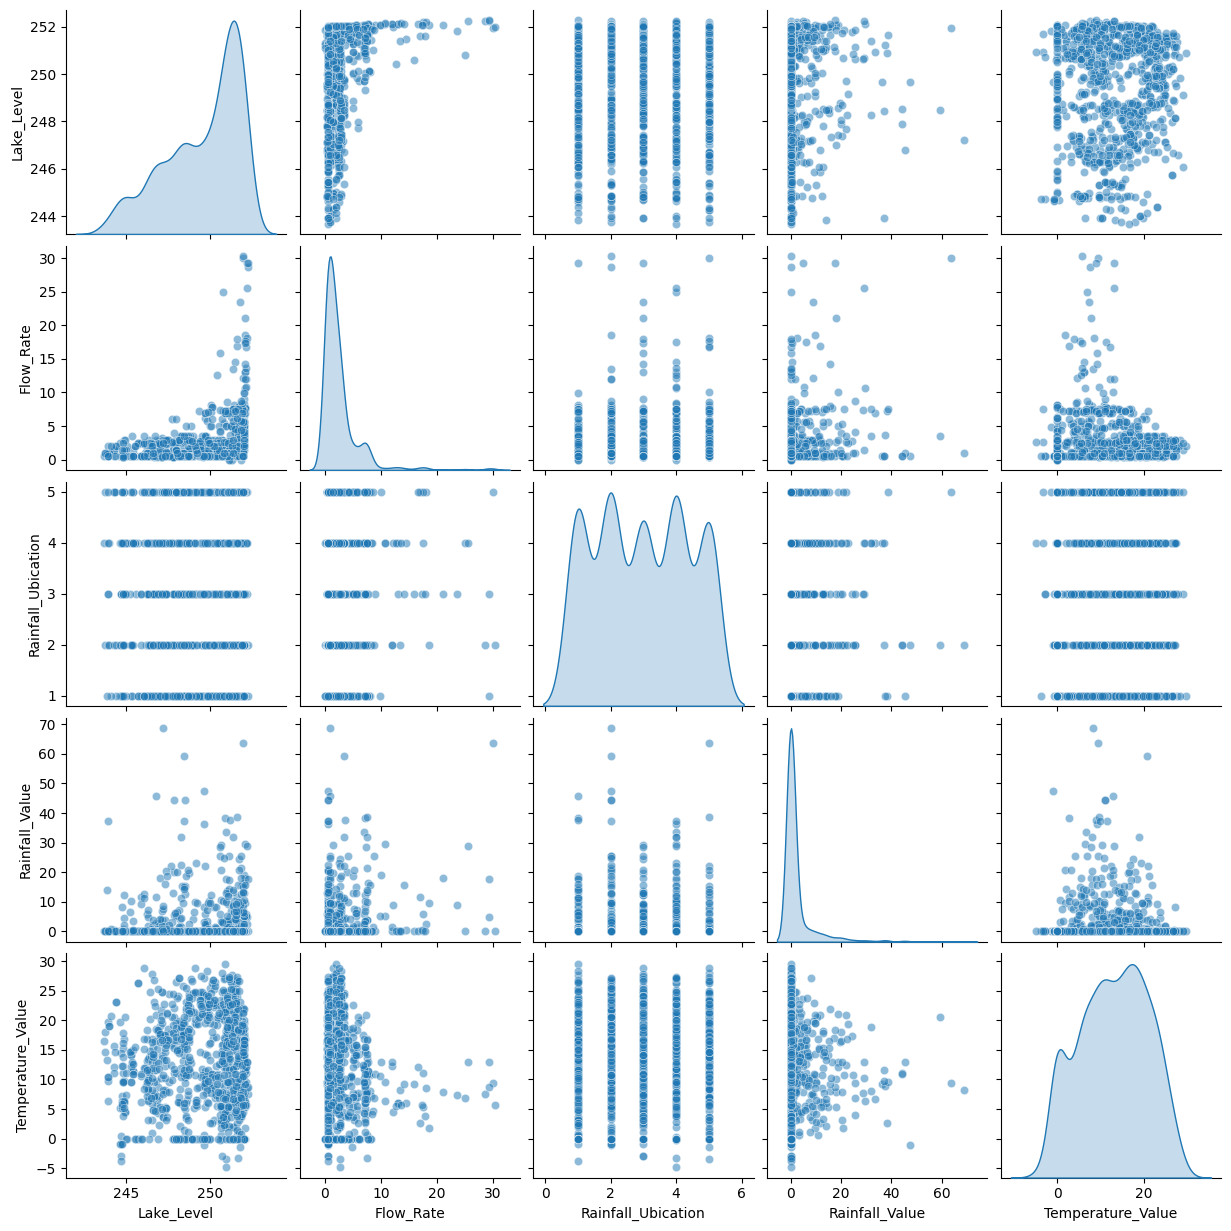

In [21]:
df_sample_lb = df_lb.sample(n=1000) # O .sample(frac=0.01) para el 1% de los datos
sns.pairplot(df_sample_lb, diag_kind='kde', markers='o', plot_kws={'alpha': 0.5})

### Correlación. 

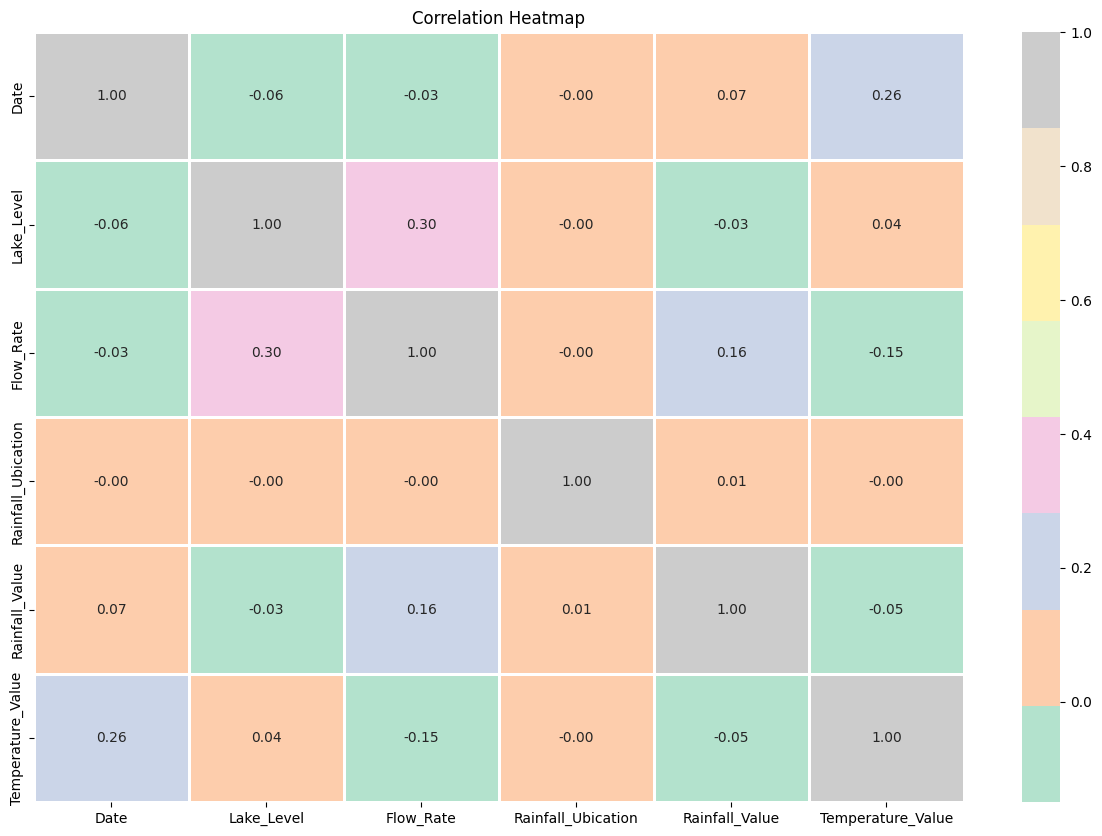

In [22]:
plt.figure(figsize=(15, 10))
sns.heatmap(df_lb.corr(), annot=True, fmt='.2f', cmap='Pastel2', linewidths=2)

plt.title('Correlation Heatmap')
plt.show()

# 6. Guardar datos limpios y preprocesados. 

In [23]:
# Guardar el DataFrame limpio y preprocesado
df_lb.to_csv('../data/processed/lakes/lake_bilancino_clean.csv', index=False)